## A comparative analysis on MS and GEM data-sets: Colombia, Ecuador and Chile

In [33]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import requests
import zipfile
import os
import json
from shapely.geometry import shape
from shapely.geometry import Polygon

from pyproj import CRS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium

## Step 1. Get the country name from user


In [34]:
country_name = input("Enter the name of the country: ")


Enter the name of the country:  Chile


In [35]:
# creates file path 

file_name = f"{country_name}.geojsonl"
base_dir ="E:/2023/Natcat/"

geojsonl_file_path = os.path.join(base_dir, f"{country_name}.geojsonl")
geojsonl_file_path

'E:/2023/Natcat/Chile.geojsonl'

## Step 2. Open the file and read its content line by line
The data type is JSON which is more suitable for unstructured data like the one we have in this project

In [36]:
with open(geojsonl_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

The following line is used to read a JSON Lines (JSONL) file and convert its contents into a list of JSON objects (Python dictionaries). 

In [37]:
json_data = [json.loads(line) for line in lines]

## Step 3. Convert JSON objects to Pandas df
is useful for turning complex JSON data structures into a more tabular form that can be easily analyzed and manipulated using Pandas.
Obviously the df contains two columns type as being Polygon and Coordinates. In the next steps I delve into the data set and explore it. 

In [38]:
df = pd.json_normalize(json_data)
df.head(3)

,type,coordinates
0,Polygon,"[[[-71.19338272520449, -34.65094635030333], [-..."
1,Polygon,"[[[-71.19872174402884, -34.91531312309422], [-..."
2,Polygon,"[[[-71.22548658231268, -32.83440017652967], [-..."


## Step 4. Exploring the df
Shape (size of df), number of unique entries (nunique) and so on

In [39]:
df.tail(3)

,type,coordinates
2208741,Polygon,"[[[-70.65258587707828, -33.39474639761417], [-..."
2208742,Polygon,"[[[-70.6532105131193, -33.18350083204412], [-7..."
2208743,Polygon,"[[[-70.6525620789975, -33.96395179478972], [-7..."


In [40]:
df.shape

(2208744, 2)

**Now checking if duplicates exist in data frame!**

The elements in the coordinates column are lists, which are mutable and therefore unhashable. The nunique function tries to use the elements of the column as keys in a dictionary (to count unique elements), but lists cannot be used as dictionary keys due to their unhashable nature. To work around this, I have converted the lists to tuples (which are immutable and hashable) before applying the nunique method.

In [ ]:
def convert_to_tuple(item):
    if isinstance(item, list):
        return tuple(convert_to_tuple(sub_item) for sub_item in item)
    return item
    
df['coordinates_tuple'] = df['coordinates'].apply(convert_to_tuple)

In [ ]:
df['coordinates_tuple'].nunique()

## Step 5. Converting coordinates to Polygons and getting areas
The generated Polygons are stored in a new column called 'geometry' in the data-frame. 
The coordinates transformed to UTM and areas calculated.
Coordinate Representation: Geographic coordinates (WGS84) use angles (degrees) to represent positions on a spherical surface.
Projected coordinates (UTM) use Cartesian coordinates (easting and northing) to represent positions on a flat surface.

In [41]:
# Convert coordinates to Polygon objects
df['geometry'] = df['coordinates'].apply(lambda x: Polygon(x[0]))

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')


In [42]:
# Print current CRS (should be EPSG:4326)
print("Current CRS:", gdf.crs)
if gdf.crs is None:
    gdf.crs = 'EPSG:4326'  # Set CRS to WGS84

Current CRS: None


In [43]:
# Project to a suitable PCS (e.g., UTM Zone 18N)
gdf = gdf.to_crs('EPSG:32618')  # UTM Zone 18N
print("updated CRS is changed to UTM!")

updated CRS is changed to UTM!


In [44]:
# Calculate areas in square meters
gdf['area_sqm'] = gdf['geometry'].area

### Now I want to get an overview of the area column 

In [45]:
# Check for NaN values
nan_count = gdf['area_sqm'].isna().sum()
print(f"Number of NaN values in area_sqm: {nan_count}")

Number of NaN values in area_sqm: 0


In [46]:
# Check for infinite values
inf_count = np.isinf(gdf['area_sqm']).sum()
print(f"Number of infinity values in area_sqm: {inf_count}")

Number of infinity values in area_sqm: 0


In [47]:
# Get descriptive statistics
area_description = gdf['area_sqm'].describe()

count = area_description['count']
mean = area_description['mean']
std = area_description['std']
min_area = area_description['min']
percentile_25 = area_description['25%']
median = area_description['50%']
percentile_75 = area_description['75%']
max_area = area_description['max']

bold_start = "\033[1m"
bold_end = "\033[0m"
print(f" min area: {bold_start}{min_area:.2f}{bold_end} sqm,\n 25th percentile: {bold_start}{percentile_25:.2f}{bold_end} sqm,\n median: {bold_start}{median:.2f}{bold_end} sqm, "
      f"\n mean area: {bold_start}{mean:.2f}{bold_end} sqm,\n 75th percentile: {bold_start}{percentile_75:.2f}{bold_end} sqm,\n max area: {bold_start}{max_area:.2f}{bold_end} sqm. "
      f"\n count of areas: {bold_start}{count}{bold_end} and\n standard deviation: {bold_start}{std:.2f}{bold_end} sqm.")

 min area: 20.03 sqm,
 25th percentile: 63.94 sqm,
 median: 107.71 sqm, 
 mean area: 199.54 sqm,
 75th percentile: 185.72 sqm,
 max area: 104991.70 sqm. 
 count of areas: 2208744.0 and
 standard deviation: 629.30 sqm.


In [48]:
# Calculate 75th percentile
percentile_75 = area_description['75%']
# Count number of areas greater than 75th percentile
count_greater_than_75th_percentile = gdf[gdf['area_sqm'] > percentile_75]['area_sqm'].count()
count_greater_than_75th_percentile


552186

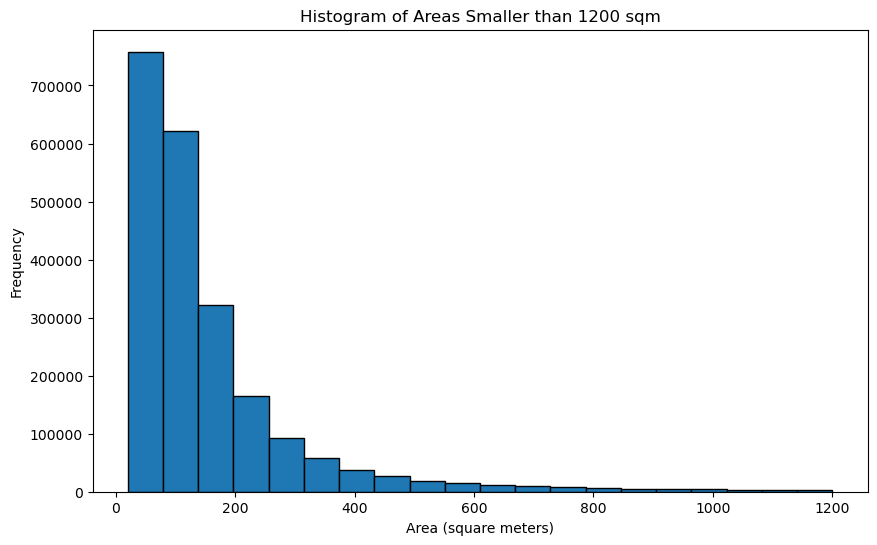

In [49]:
# Plot histogram of area_sqm
threshold = 1200 
gdf_filtered = gdf[gdf['area_sqm'] <= threshold]

# Plot histogram of area_sqm
plt.figure(figsize=(10, 6))
plt.hist(gdf_filtered['area_sqm'], bins=20, edgecolor='black')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Areas Smaller than {threshold} sqm')
plt.grid(False)
plt.show()

In [50]:
gdf

,type,coordinates,geometry,area_sqm
0,Polygon,"[[[-71.19338272520449, -34.65094635030333], [-...","POLYGON ((848920.144 -3840931.451, 848919.504 ...",35.341827
1,Polygon,"[[[-71.19872174402884, -34.91531312309422], [-...","POLYGON ((847318.445 -3870251.848, 847313.835 ...",26.867006
2,Polygon,"[[[-71.22548658231268, -32.83440017652967], [-...","POLYGON ((853362.600 -3639245.347, 853351.873 ...",94.939074
3,Polygon,"[[[-71.19820778002867, -34.76658383856646], [-...","POLYGON ((847992.058 -3853747.858, 847995.776 ...",140.662879
4,Polygon,"[[[-71.22528620692486, -32.99065420576912], [-...","POLYGON ((852759.827 -3656583.617, 852765.594 ...",137.619832
...,...,...,...,...
2208739,Polygon,"[[[-70.65303240440008, -33.54510264910624], [-...","POLYGON ((903712.015 -3720192.270, 903722.849 ...",345.377342
2208740,Polygon,"[[[-70.65306764901648, -33.90179048282484], [-...","POLYGON ((902037.895 -3759783.140, 902026.697 ...",63.364102
2208741,Polygon,"[[[-70.65258587707828, -33.39474639761417], [-...","POLYGON ((904453.227 -3703505.322, 904443.075 ...",545.113161
2208742,Polygon,"[[[-70.6532105131193, -33.18350083204412], [-7...","POLYGON ((905373.290 -3680056.126, 905376.443 ...",49.038396


## Step 6. Graphs !

In [51]:
import geopandas as gpd

country_abbreviation = input("Enter the country abbreviation (e.g., ECU for Ecuador): ").strip().upper()
# Load the GADM shapefile for Ecuador (adjust the path to where you downloaded the file)
file_path = rf'E:/2023/Natcat/gadm41_{country_abbreviation}_1.shp'
provinces_gdf = gpd.read_file(file_path)

Enter the country abbreviation (e.g., ECU for Ecuador):  CHL


In [52]:
# Ensure both GeoDataFrames have the same CRS
provinces_gdf = provinces_gdf.to_crs(gdf.crs)


In [53]:
print(provinces_gdf.crs)
print(gdf.crs)

EPSG:32618
EPSG:32618


In [54]:
# sapitial join of the two dfs (it will allocate polygons to provinces)
gdf_with_provinces = gpd.sjoin(gdf,  provinces_gdf, how='left', predicate='within')


In [55]:
gdf_with_provinces['NAME_1'].isnull().sum()


217

In [ ]:
import unidecode
def normalize_province_name(name):
    if isinstance(name, str):
        return unidecode.unidecode(name).lower()
    else:
        return name

# Normalize the province names in the province GeoDataFrame
#gdf_with_provinces['province_normalized'] = gdf_with_provinces['province_name'].apply(normalize_province_name)
provinces_gdf['province_normalized'] = provinces_gdf['NAME_1'].apply(normalize_province_name)
gdf_with_provinces['province_normalized'] = gdf_with_provinces['NAME_1'].apply(normalize_province_name)


### Count the number of rows (polygons) in each province as the number of bldgs


In [56]:
province_total_polygons = gdf_with_provinces.groupby('NAME_1').size().reset_index(name='counts')
province_total_areas = gdf_with_provinces.groupby('NAME_1')['area_sqm'].sum().reset_index()

ms_df = pd.merge(province_total_polygons, province_total_areas, on='NAME_1')
ms_df

,NAME_1,counts,area_sqm
0,Arica y Parinacota,178,1.839231e+04
1,Libertador General Bernardo O'Hi,320319,5.756078e+07
2,Maule,90317,1.949176e+07
3,Santiago Metropolitan,1126887,2.557032e+08
4,Valparaíso,670826,1.078876e+08


In [57]:
ms_df['counts'].sum()

2208527

In [64]:
ms_df = ms_df.rename(columns={'NAME_1': 'province_name'})
ms_df.to_csv('chi_MS.csv', index=False)
ms_df

,province_name,counts,area_sqm
0,Arica y Parinacota,178,1.839231e+04
1,Libertador General Bernardo O'Hi,320319,5.756078e+07
2,Maule,90317,1.949176e+07
3,Santiago Metropolitan,1126887,2.557032e+08
4,Valparaíso,670826,1.078876e+08


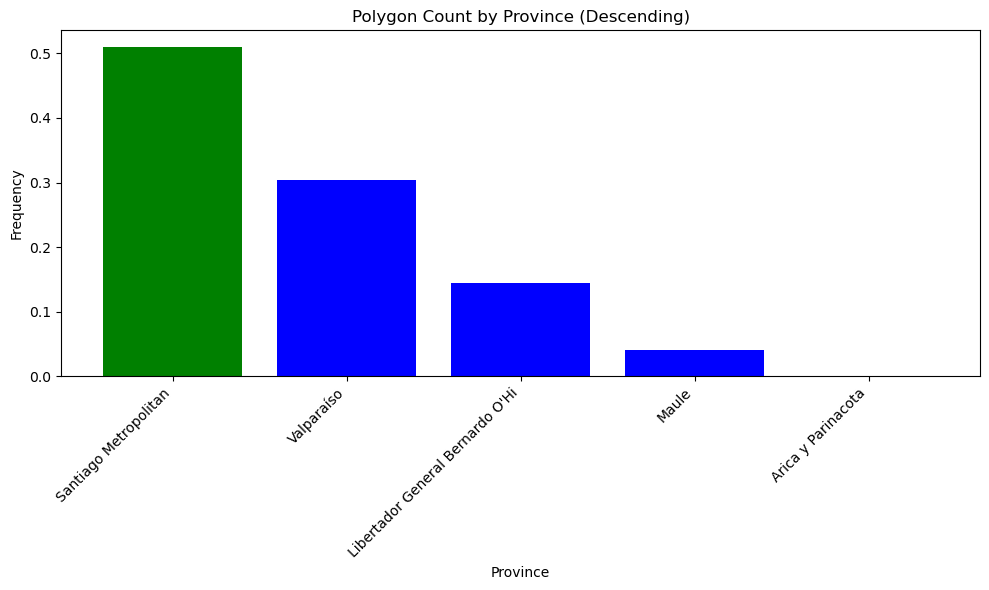

In [60]:
import matplotlib.pyplot as plt
province_polygons_sorted = province_total_polygons.sort_values(by='counts', ascending=False)

# Calculating frequencies
total_polygons = province_polygons_sorted['counts'].sum()
province_polygons_sorted['frequency'] = province_polygons_sorted['counts'] / total_polygons

# Calculate cumulative frequencies
province_polygons_sorted['cumulative_frequency'] = province_polygons_sorted['frequency'].cumsum()

# Find index where cumulative frequency reaches 80%
highlight_index = (province_polygons_sorted['cumulative_frequency'] <= 0.8).sum()

# Plot Pareto histogram
plt.figure(figsize=(10, 6))

# Plot all bars
plt.bar(province_polygons_sorted['NAME_1'], province_polygons_sorted['frequency'], color='blue')

# Highlighting bars contributing to 80% cumulative frequency
plt.bar(province_polygons_sorted['NAME_1'][:highlight_index], 
        province_polygons_sorted['frequency'][:highlight_index], 
        color='green')

plt.title('Polygon Count by Province (Descending)')
plt.xlabel('Province')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.grid(False)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

In [61]:
# Merge the counts with the province_name
#merged_gdf = provinces_gdf.merge(ms_df, on='province_normalized')
provinces_gdf = provinces_gdf.merge(ms_df, left_on='NAME_1', right_on='province_name', how='left')

In [62]:
# Fill NaN values in 'counts' with 0 
provinces_gdf['counts'] = provinces_gdf['counts'].fillna(0)

<Figure size 1200x800 with 0 Axes>

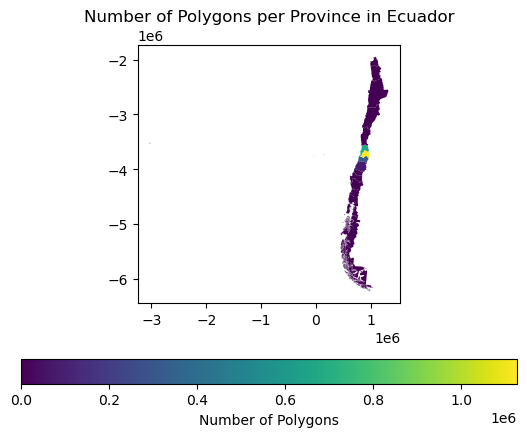

In [63]:
plt.figure(figsize=(12, 8))
provinces_gdf.plot(column='counts', cmap='viridis', legend=True,
                   legend_kwds={'label': "Number of Polygons",
                                'orientation': "horizontal"})
plt.title('Number of Polygons per Province in Ecuador')
plt.show()

In [ ]:
print(gdf.head())